In [1]:
%load_ext autoreload
%autoreload 2

import wandb
import torch
from jaspertorch import TinyJasper, CTCLossNM
from optimizers import AdamW
from loader import *

wandb.init(project='jasper')
config = wandb.config

config.lr = 1e-3
config.epochs = 30

# ocr = TinyJasper('../models/0.ocr').cuda()
ocr = torch.load('../models/1.ocr').cuda()
loss_fn = CTCLossNM(num_classes=len(ocr.charList)+1)
optimizer = AdamW(ocr.parameters(), lr=config.lr)

In [5]:
wandb.watch(ocr)

In [2]:
from load_data import ocr_dataset
from torch.utils.data import DataLoader

trn_dl = DataLoader(ocr_dataset('../data/nums-synth/train'), 
                    batch_size=128, 
                    shuffle=True, num_workers=3)
N_trn_batches = len(trn_dl)

val_dl = DataLoader(ocr_dataset('../data/nums-synth/val', validation=True), 
                    batch_size=128, 
                    shuffle=True, num_workers=3)


2019-11-27 11:34:50.882 | INFO     | loader:Glob:57 - 100000 files found at ../data/nums-synth/train
2019-11-27 11:34:50.905 | INFO     | loader:Glob:57 - 8994 files found at ../data/nums-synth/val


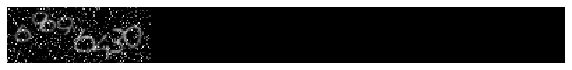

In [3]:
show(trn_dl.dataset[0][0])

In [4]:
val_results = []
for ix, (ims, labels, _) in enumerate(val_dl):
    val_results.append(ocr.evaluate(ims.cuda(), labels))
    
val_results = pd.DataFrame(val_results).describe().loc['mean'].squeeze().to_dict()
best_acc = val_results['word-accuracy']
print("Current best validation accuracy - {:.2f} %".format(best_acc*100))

Current best validation accuracy - 71.69 %


In [7]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter(logdir=f'../runs/synthnums_1L/')

start_epoch = 0
for ep in range(config.epochs):
    try:
        if ep == 100:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
        ocr.training = True
        for ix, (ims, labels, _) in enumerate(trn_dl):
            step = ep * N_trn_batches + ix + 1
            optimizer.zero_grad()
            preds = ocr(ims.cuda())
            targets = torch.cat([ocr.str2vec(target)[None] for target in labels]).cuda()
            target_lengths = torch.tensor([len(target) for target in labels]).long().cuda()
            input_lengths = torch.tensor([100]*len(ims)).long().cuda()
            loss = loss_fn(preds, targets, input_lengths, target_lengths)
            loss.backward()
            # writer.add_scalar('train/loss', loss.item(), int(step))
            print(f'iter: {ep+(ix/N_trn_batches):.3f}\tLoss: {loss.item():.3f}', end='\r')
            wandb.log({'Train Loss': loss.item()})
            optimizer.step()
        val_results = []
        for ix, (ims, labels, _) in enumerate(val_dl):
            val_results.append(ocr.evaluate(ims.cuda(), labels))
        val_results = pd.DataFrame(val_results).describe().loc['mean'].squeeze().to_dict()
        # writer.add_scalar('validation/word-accuracy', val_results['word-accuracy'], ep)
        # writer.add_scalar('validation/char-accuracy', val_results['char-accuracy'], ep)
        ocr.training = False
        examples = []
        for _ in range(10):
            ix = randint(len(val_dl.dataset))
            im = val_dl.dataset[ix][0]
            caption = ocr.decoder_chars(ocr(im[None].cuda()))
            examples.append(wandb.Image(im, caption=caption))
        wandb.log({
            'Validation Word Accuracy': val_results['word-accuracy'],
            'Validation Char Accuracy': val_results['char-accuracy'],
            'Examples': examples
        })
        print(f"epoch: {ep+1:.3f}\t\tWord Acc: {val_results['word-accuracy']:.3f}\t\tChar Acc: {val_results['char-accuracy']:.3f}")
        if val_results['word-accuracy'] > best_acc:
              logger.info('Saving...')
              torch.save(ocr, '../models/1.ocr')
              best_acc = val_results['word-accuracy']
    except KeyboardInterrupt:
        start_epoch = ep

2019-11-27 11:49:03.841 | INFO     | __main__:<module>:44 - Saving...


epoch: 1.000		Word Acc: 0.725		Char Acc: 0.935


/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type TinyJasper. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type C. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be ch

2019-11-27 11:54:49.275 | INFO     | __main__:<module>:44 - Saving...


epoch: 2.000		Word Acc: 0.736		Char Acc: 0.937
epoch: 3.000		Word Acc: 0.735		Char Acc: 0.936


2019-11-27 12:06:24.746 | INFO     | __main__:<module>:44 - Saving...


epoch: 4.000		Word Acc: 0.736		Char Acc: 0.937


2019-11-27 12:12:12.921 | INFO     | __main__:<module>:44 - Saving...


epoch: 5.000		Word Acc: 0.738		Char Acc: 0.938


2019-11-27 12:17:50.738 | INFO     | __main__:<module>:44 - Saving...


epoch: 6.000		Word Acc: 0.742		Char Acc: 0.939
epoch: 7.000		Word Acc: 0.735		Char Acc: 0.937
epoch: 8.000		Word Acc: 0.732		Char Acc: 0.937
epoch: 9.000		Word Acc: 0.742		Char Acc: 0.939
epoch: 10.000		Word Acc: 0.740		Char Acc: 0.938
epoch: 11.000		Word Acc: 0.740		Char Acc: 0.939


2019-11-27 12:50:23.664 | INFO     | __main__:<module>:44 - Saving...


epoch: 12.000		Word Acc: 0.742		Char Acc: 0.940


2019-11-27 12:55:48.687 | INFO     | __main__:<module>:44 - Saving...


epoch: 13.000		Word Acc: 0.747		Char Acc: 0.939
epoch: 14.000		Word Acc: 0.741		Char Acc: 0.939
epoch: 15.000		Word Acc: 0.741		Char Acc: 0.940
epoch: 16.000		Word Acc: 0.746		Char Acc: 0.939
epoch: 17.000		Word Acc: 0.740		Char Acc: 0.938
epoch: 18.000		Word Acc: 0.746		Char Acc: 0.940
epoch: 19.000		Word Acc: 0.743		Char Acc: 0.938
epoch: 20.000		Word Acc: 0.742		Char Acc: 0.940
epoch: 21.000		Word Acc: 0.741		Char Acc: 0.939


2019-11-27 13:45:37.999 | INFO     | __main__:<module>:44 - Saving...


epoch: 22.000		Word Acc: 0.747		Char Acc: 0.940


2019-11-27 13:51:06.528 | INFO     | __main__:<module>:44 - Saving...


epoch: 23.000		Word Acc: 0.749		Char Acc: 0.941
epoch: 24.000		Word Acc: 0.743		Char Acc: 0.939
epoch: 25.000		Word Acc: 0.739		Char Acc: 0.938
epoch: 26.000		Word Acc: 0.746		Char Acc: 0.939
epoch: 27.000		Word Acc: 0.741		Char Acc: 0.940
epoch: 28.000		Word Acc: 0.749		Char Acc: 0.940
epoch: 29.000		Word Acc: 0.747		Char Acc: 0.940


2019-11-27 14:30:02.760 | INFO     | __main__:<module>:44 - Saving...


epoch: 30.000		Word Acc: 0.750		Char Acc: 0.940


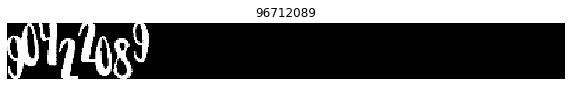

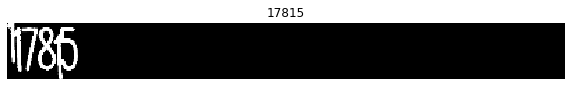

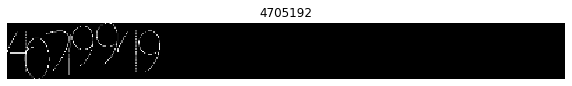

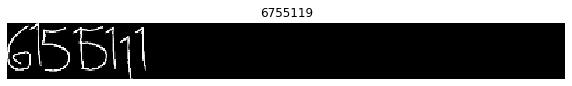

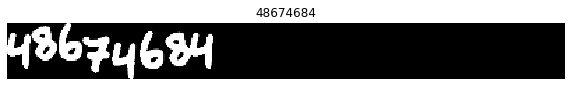

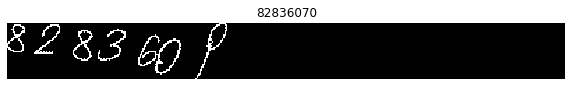

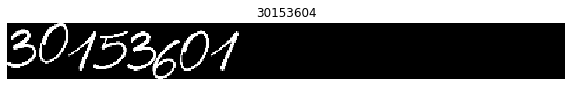

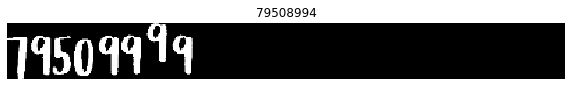

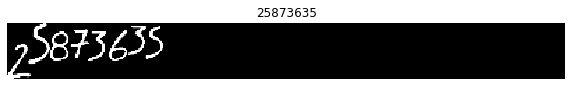

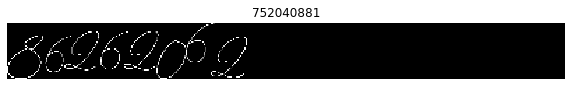

In [7]:
ocr.training = False
for _ in range(10):
    ix = randint(len(val_dl.dataset))
    im = val_dl.dataset[ix][0]
    show(im, title=ocr.decoder_chars(ocr(im[None].cuda())))